Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/My Drive/Train/")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Test/")

In [4]:
# Total images in train and test data
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [5]:
# Creating data frame with path and label for the train data
path_list = [x for x in glob(os.path.join('/content/gdrive/My Drive/Train/', '*','*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join('/content/gdrive/My Drive/Train/','*','*.jpg'))]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/My Drive/Train/", batch_size=32, image_size=(180,180), seed=123, validation_split=0.2, subset='training'
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/My Drive/Train/", batch_size=32, image_size=(180,180), seed=123, validation_split=0.2, subset='validation'
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

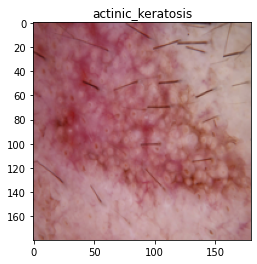

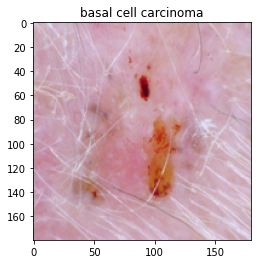

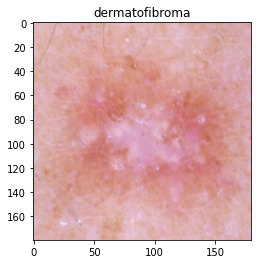

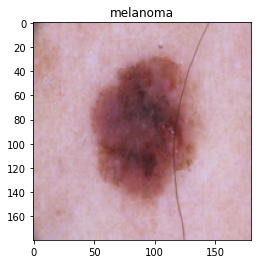

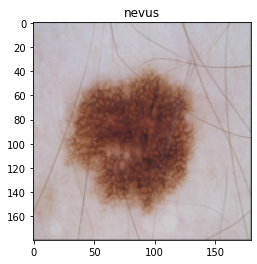

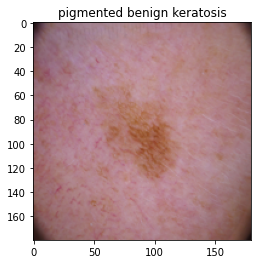

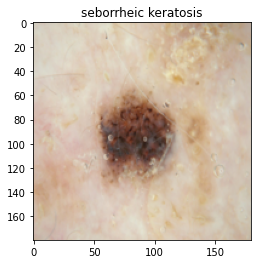

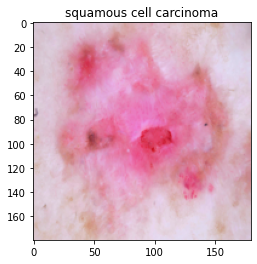

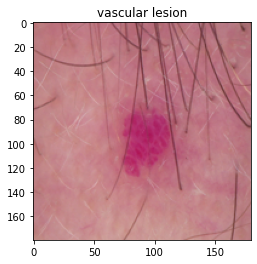

In [10]:
# Displaing one instance of all the nine classes present in the train dataset
from matplotlib import pyplot
import matplotlib.pyplot as plt
from PIL import Image

image_1 = Image.open("/content/gdrive/My Drive/Train/actinic keratosis/ISIC_0025780.jpg")
image_1 = image_1.resize((180,180))
plt.imshow(image_1)
plt.title('actinic_keratosis')
plt.show()

image_2 = Image.open("/content/gdrive/My Drive/Train/basal cell carcinoma/ISIC_0024504.jpg")
image_2 = image_2.resize((180,180))
plt.imshow(image_2)
plt.title('basal cell carcinoma')
plt.show()

image_3 = Image.open("/content/gdrive/My Drive/Train/dermatofibroma/ISIC_0025223.jpg")
image_3 = image_3.resize((180,180))
plt.imshow(image_3)
plt.title('dermatofibroma')
plt.show()

image_4 = Image.open("/content/gdrive/My Drive/Train/melanoma/ISIC_0000139.jpg")
image_4 = image_4.resize((180,180))
plt.imshow(image_4)
plt.title('melanoma')
plt.show()

image_5 = Image.open("/content/gdrive/My Drive/Train/nevus/ISIC_0000019.jpg")
image_5 = image_5.resize((180,180))
plt.imshow(image_5)
plt.title('nevus')
plt.show()

image_6 = Image.open("/content/gdrive/My Drive/Train/pigmented benign keratosis/ISIC_0024435.jpg")
image_6 = image_6.resize((180,180))
plt.imshow(image_6)
plt.title('pigmented benign keratosis')
plt.show()

image_7 = Image.open("/content/gdrive/My Drive/Train/seborrheic keratosis/ISIC_0010810.jpg")
image_7 = image_7.resize((180,180))
plt.imshow(image_7)
plt.title('seborrheic keratosis')
plt.show()

image_8 = Image.open("/content/gdrive/My Drive/Train/squamous cell carcinoma/ISIC_0024710.jpg")
image_8 = image_8.resize((180,180))
plt.imshow(image_8)
plt.title('squamous cell carcinoma')
plt.show()

image_9 = Image.open("/content/gdrive/My Drive/Train/vascular lesion/ISIC_0024475.jpg")
image_9 = image_9.resize((180,180))
plt.imshow(image_9)
plt.title('vascular lesion')
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [12]:
# Defining the model
model = Sequential([
   layers.experimental.preprocessing.Rescaling(1./255),
   layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(180, 180, 3)),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
   layers.MaxPooling2D((2,2)),
   layers.Conv2D(128, (3, 3), activation='relu'),
   layers.Flatten(),
   layers.Dense(128, activation='relu'),
   layers.Dense(9, activation='softmax')
])  

### Compile the model

In [13]:
# Compiling the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

### Train the model

In [14]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 671s 3s/step - loss: 9.4665 - accuracy: 0.2271 - val_loss: 1.9272 - val_accuracy: 0.3333
Epoch 2/20
56/56 [==============================] - 2s 38ms/step - loss: 1.8565 - accuracy: 0.2994 - val_loss: 1.7400 - val_accuracy: 0.3982
Epoch 3/20
56/56 [==============================] - 2s 39ms/step - loss: 1.6240 - accuracy: 0.4280 - val_loss: 1.6118 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.5228 - accuracy: 0.4703 - val_loss: 1.5266 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.5185 - accuracy: 0.4904 - val_loss: 1.5409 - val_accuracy: 0.4810
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3423 - accuracy: 0.5196 - val_loss: 1.4762 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3155 - accuracy: 0.5354 - val_loss: 1.4880 - val_accuracy: 0.4989
Epoch 8/20
56

In [15]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 41, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 215168)            0

### Visualizing training results

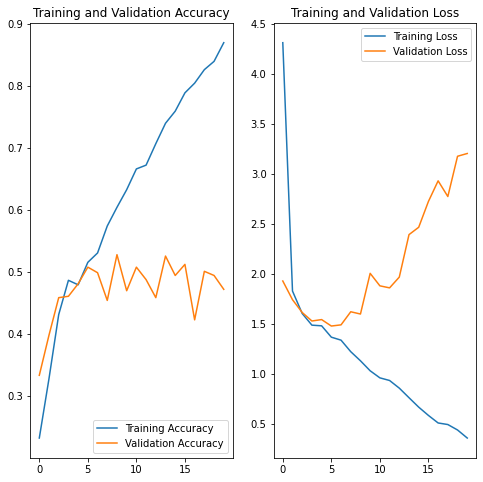

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## As can be seen that, the training accuracy is above 86.85% and validation accuracy is 47.20%. Thus there is large over-fitting visible in the model.

In [17]:
# Data Augmentation Strategy
# Flip the images horizontal. Ramdon rotation of the data by 0.1

# Defining the model
model = Sequential([
   layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(180, 180, 3)),
   layers.experimental.preprocessing.RandomRotation(0.1),
   layers.experimental.preprocessing.Rescaling(1./255),
   layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', input_shape=(180, 180, 3)),
   layers.MaxPooling2D((2,2)),
   layers.Dropout(0.25),
   layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
   layers.MaxPooling2D((2,2)),
   layers.Dropout(0.25),
   layers.Conv2D(128, (3, 3), activation='relu'),
   layers.Dropout(0.40),
   layers.Flatten(),
   layers.Dense(128, activation='relu'),
   layers.Dense(9, activation='softmax')
 ])  # OUTPUT

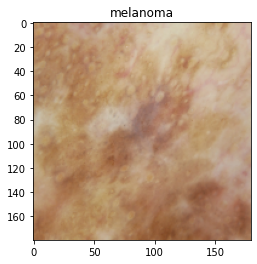

In [18]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
data_augmentation = Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(180, 
                                                              180,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),      
  ]
)

for image, label in train_ds.take(1):
    augmented_image = data_augmentation(image)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.title(class_names[label[0]])
    plt.show()


### Create the model, compile and train the model

In [19]:
# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [20]:
# Model fit
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
56/56 [==============================] - 3s 49ms/step - loss: 14.0339 - accuracy: 0.1710 - val_loss: 1.9544 - val_accuracy: 0.2125
Epoch 2/20
56/56 [==============================] - 3s 47ms/step - loss: 1.9292 - accuracy: 0.2758 - val_loss: 2.2140 - val_accuracy: 0.2394
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.8122 - accuracy: 0.3650 - val_loss: 4.9731 - val_accuracy: 0.1991
Epoch 4/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6068 - accuracy: 0.4065 - val_loss: 2.7971 - val_accuracy: 0.2371
Epoch 5/20
56/56 [==============================] - 3s 47ms/step - loss: 1.6416 - accuracy: 0.4136 - val_loss: 2.2022 - val_accuracy: 0.2752
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4975 - accuracy: 0.4843 - val_loss: 1.9524 - val_accuracy: 0.3557
Epoch 7/20
56/56 [==============================] - 3s 47ms/step - loss: 1.4917 - accuracy: 0.4653 - val_loss: 2.4909 - val_accuracy: 0.2550
Epoch 8/20
5

In [21]:
# Model Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 180, 180, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 87, 87, 64)       

### Visualizing the results

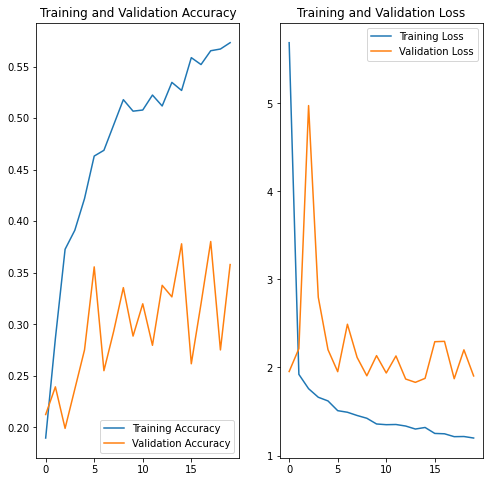

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## The training accuracy is 56.33% and validation accuracy is 35.79%. Thus there is reduction in overfitting of the model. But the model is also underfitting.

##Distribution of classes in the dataset

In [23]:
import glob 

# Defining count variable to count images in each class in train data
count_1 = 0
count_2 = 0
count_3 = 0
count_4 = 0
count_5 = 0
count_6 = 0
count_7 = 0
count_8 = 0
count_9 = 0

# counting images in each class in train data
for img in glob.glob('/content/gdrive/My Drive/Train/actinic keratosis/*.jpg'):
  count_1 = count_1 +1

for img in glob.glob('/content/gdrive/My Drive/Train/basal cell carcinoma/*.jpg'):
  count_2 = count_2 +1

for img in glob.glob('/content/gdrive/My Drive/Train/dermatofibroma/*.jpg'):
  count_3 = count_3 +1

for img in glob.glob('/content/gdrive/My Drive/Train/melanoma/*.jpg'):
  count_4 = count_4 +1

for img in glob.glob('/content/gdrive/My Drive/Train/nevus/*.jpg'):
  count_5 = count_5 +1

for img in glob.glob('/content/gdrive/My Drive/Train/pigmented benign keratosis/*.jpg'):
  count_6 = count_6 +1

for img in glob.glob('/content/gdrive/My Drive/Train/seborrheic keratosis/*.jpg'):
  count_7 = count_7 +1

for img in glob.glob('/content/gdrive/My Drive/Train/squamous cell carcinoma/*.jpg'):
  count_8 = count_8 +1

for img in glob.glob('/content/gdrive/My Drive/Train/vascular lesion/*.jpg'):
  count_9 = count_9 +1

total_count = count_1 + count_2 + count_3 + count_4 + count_5 + count_6 + count_7 + count_8 + count_9

# counting percentage of images in each class in train data out of total images in train data
percentage_image_count_train_1 = count_1 / total_count*100
percentage_image_count_train_2 = count_2 / total_count*100
percentage_image_count_train_3 = count_3 / total_count*100
percentage_image_count_train_4 = count_4 / total_count*100
percentage_image_count_train_5 = count_5 / total_count*100
percentage_image_count_train_6 = count_6 / total_count*100
percentage_image_count_train_7 = count_7 / total_count*100
percentage_image_count_train_8 = count_8 / total_count*100
percentage_image_count_train_9 = count_9 / total_count*100
 
# upto 2 decimal places
percentage_image_count_train_11 = "{:.2f}".format(percentage_image_count_train_1)
percentage_image_count_train_12 = "{:.2f}".format(percentage_image_count_train_2)
percentage_image_count_train_13 = "{:.2f}".format(percentage_image_count_train_3)
percentage_image_count_train_14 = "{:.2f}".format(percentage_image_count_train_4)
percentage_image_count_train_15 = "{:.2f}".format(percentage_image_count_train_5)
percentage_image_count_train_16 = "{:.2f}".format(percentage_image_count_train_6)
percentage_image_count_train_17 = "{:.2f}".format(percentage_image_count_train_7)
percentage_image_count_train_18 = "{:.2f}".format(percentage_image_count_train_8)
percentage_image_count_train_19 = "{:.2f}".format(percentage_image_count_train_9)

# printing the percentage of images in each class in train data out of total images in train data
print(f'Percentage of images for actinic kerstosis is: {percentage_image_count_train_11} %')
print(f'Percentage of images for basal cell carcinoma is: {percentage_image_count_train_12} %')
print(f'Percentage of images for dermatofibroma is: {percentage_image_count_train_13} %')
print(f'Percentage of images for melanoma is: {percentage_image_count_train_14} %')
print(f'Percentage of images for nevus is: {percentage_image_count_train_15} %')
print(f'Percentage of images for pigmented benign keratosis is: {percentage_image_count_train_16} %')
print(f'Percentage of images for seborrheic keratosis is: {percentage_image_count_train_17} %')
print(f'Percentage of images for squamous cell carcinoma is: {percentage_image_count_train_18} %')
print(f'Percentage of images for vascular lesion is: {percentage_image_count_train_19} %')

Percentage of images for actinic kerstosis is: 5.09 %
Percentage of images for basal cell carcinoma is: 16.79 %
Percentage of images for dermatofibroma is: 4.24 %
Percentage of images for melanoma is: 19.56 %
Percentage of images for nevus is: 15.94 %
Percentage of images for pigmented benign keratosis is: 20.63 %
Percentage of images for seborrheic keratosis is: 3.44 %
Percentage of images for squamous cell carcinoma is: 8.08 %
Percentage of images for vascular lesion is: 6.21 %



#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
!pip install Augmentor

In [25]:
path_to_training_dataset="/content/gdrive/My Drive/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F10501E2550>: 100%|██████████| 500/500 [00:18<00:00, 26.71 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F106758DDD8>: 100%|██████████| 500/500 [00:18<00:00, 26.52 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F1060684080>: 100%|██████████| 500/500 [00:19<00:00, 25.61 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=722x542 at 0x7F1001E9A400>: 100%|██████████| 500/500 [01:26<00:00,  5.78 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F10500B5E48>: 100%|██████████| 500/500 [01:17<00:00,  6.47 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F105034FE80>: 100%|██████████| 500/500 [00:18<00:00, 26.52 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F10502C7EF0>: 100%|██████████| 500/500 [00:42<00:00, 11.87 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F10080325F8>: 100%|██████████| 500/500 [00:19<00:00, 26.26 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F10606840B8>: 100%|██████████| 500/500 [00:19<00:00, 26.08 Samples/s]


In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [27]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [28]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [30]:
df3 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df3.shape

(4500, 2)

In [31]:
new_df = original_df.append(df3)

In [32]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance.

#### Train the model on the data created using Augmentor

In [33]:
batch_size = 32
img_height = 180
img_width = 180

In [34]:
## Write train dataset
train_ds_1 = tf.keras.preprocessing.image_dataset_from_directory("/content/gdrive/My Drive/Train/", batch_size=32, image_size=(180,180), seed=123, validation_split=0.2, subset='training')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [35]:
## Write validation dataset
validation_ds_1 = tf.keras.preprocessing.image_dataset_from_directory("/content/gdrive/My Drive/Train/", batch_size=32, image_size=(180,180), seed=123, validation_split=0.2, subset='validation')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [37]:
# Create Model

# Defining the model
model = Sequential([
   layers.experimental.preprocessing.Rescaling(1./255),
   layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
   layers.MaxPooling2D((2,2)),
   layers.Dropout(0.25),
   layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
   layers.MaxPooling2D((2,2)),
   layers.Dropout(0.25),
   layers.Conv2D(128, (3, 3), activation='relu'),
   layers.Dropout(0.25),
   layers.Flatten(),
   layers.Dense(128, activation='relu'),
   layers.Dense(9, activation='softmax')
 ])  # OUTPUT

In [38]:
# Compile Model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])

In [39]:
# Train Model
epochs = 20
history = model.fit(train_ds_1, validation_data=validation_ds_1, epochs=epochs)

Epoch 1/20
169/169 [==============================] - 45s 254ms/step - loss: 3.9216 - accuracy: 0.1431 - val_loss: 2.0171 - val_accuracy: 0.2056
Epoch 2/20
169/169 [==============================] - 43s 250ms/step - loss: 1.9316 - accuracy: 0.2430 - val_loss: 1.7269 - val_accuracy: 0.3177
Epoch 3/20
169/169 [==============================] - 43s 250ms/step - loss: 1.6398 - accuracy: 0.3708 - val_loss: 1.5075 - val_accuracy: 0.4261
Epoch 4/20
169/169 [==============================] - 43s 248ms/step - loss: 1.4716 - accuracy: 0.4398 - val_loss: 1.4456 - val_accuracy: 0.4573
Epoch 5/20
169/169 [==============================] - 43s 250ms/step - loss: 1.3625 - accuracy: 0.4813 - val_loss: 1.3811 - val_accuracy: 0.4885
Epoch 6/20
169/169 [==============================] - 43s 247ms/step - loss: 1.2575 - accuracy: 0.5292 - val_loss: 1.3099 - val_accuracy: 0.5078
Epoch 7/20
169/169 [==============================] - 43s 249ms/step - loss: 1.1455 - accuracy: 0.5778 - val_loss: 1.2097 - val_ac

In [40]:
# Model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 43, 43, 64)       

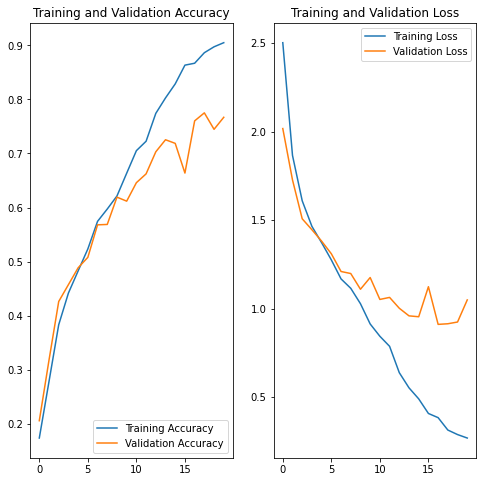

In [41]:
# Visualize the Model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## The training and vaidation accuracy has increased a lot. 
## Training accuracy: 90.61%
## Validation accuracu: 76.69%
## This moldel has also got rid of overfitting and underfitting upto a large extent
## Class balance and Image Augmentation has helped a lot